In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

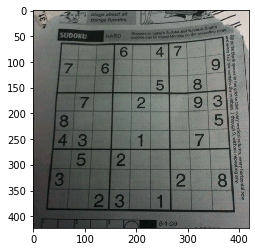

In [2]:
image = cv2.imread('1.jpg')
gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
plt.imshow(image)

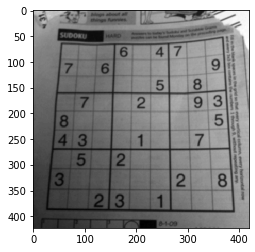

In [3]:
blur_image = cv2.GaussianBlur(gray_image,(5,5),0)
plt.imshow(blur_image, cmap='gray')

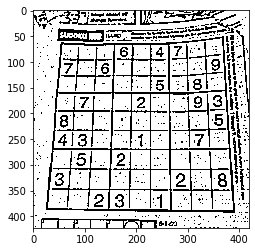

In [4]:
thresh = cv2.adaptiveThreshold(blur_image,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11 , 2)
plt.imshow(thresh, cmap='gray')

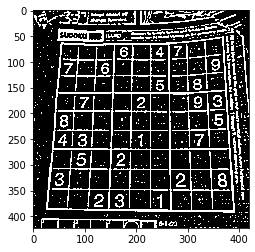

In [5]:
binary_image = cv2.bitwise_not(thresh)
plt.imshow(binary_image, cmap = 'gray')

In [6]:
line_image = binary_image
temp = image
minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(line_image,1,np.pi/180,100,minLineLength,maxLineGap)
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(temp,(x1,y1),(x2,y2),(0,255,0),1)

In [7]:
cv2.imshow('',temp)
cv2.waitKey()
cv2.destroyAllWindows()

In [8]:
contours, hierarchy = cv2.findContours(line_image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#contour_image = cv2.drawContours(image, contours, -1, (0,255,0), 1)

In [9]:
area = -1
for i in range(len(contours)):
    if cv2.contourArea(contours[i])>area:
        area = cv2.contourArea(contours[i])
        index = i
        print('area:',area)
        print('index:',i)
max_area = area
'''
area = -1
for i in range(len(contours)):
    if cv2.contourArea(contours[i])> area and cv2.contourArea(contours[i])<max_area:
        area = cv2.contourArea(contours[i])
        print('index:',i)
        print('area:',area)'''

area: 0.0
index: 0
area: 1.0
index: 5
area: 3.0
index: 7
area: 3.5
index: 8
area: 4.0
index: 10
area: 4.5
index: 27
area: 111.5
index: 34
area: 937.5
index: 53
area: 111440.0
index: 334


"\narea = -1\nfor i in range(len(contours)):\n    if cv2.contourArea(contours[i])> area and cv2.contourArea(contours[i])<max_area:\n        area = cv2.contourArea(contours[i])\n        print('index:',i)\n        print('area:',area)"

In [10]:
temp2 = image
contour_image = cv2.drawContours(temp2,[contours[index]],0, (0,0,255),2)
cv2.imshow('',contour_image)
cv2.waitKey()
cv2.destroyAllWindows()

In [11]:
cnt = contours[index]
epsilon = 0.1*cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt,epsilon,True)
approx

array([[[369,  51]],

       [[ 55,  63]],

       [[ 25, 387]],

       [[390, 392]]], dtype=int32)

In [12]:
pts1 = np.float32(approx.reshape(4,2))
pts2 = np.float32([[252,0],[0,0],[0,252],[252,252]])

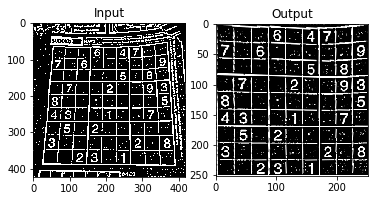

In [13]:
M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(binary_image,M,(252,252))
plt.subplot(121),plt.imshow(binary_image,cmap='gray'),plt.title('Input')
plt.subplot(122),plt.imshow(dst,cmap='gray'),plt.title('Output')
plt.show()

In [14]:
x_size, y_size = 28, 28
number_images = []
for y in range(1,10):
    for x in range(1,10):
        number_images.append(dst[(y-1)*y_size:y*y_size,(x-1)*x_size:x*x_size])

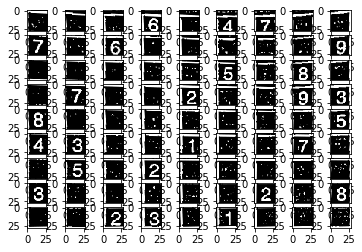

In [15]:
for i in range(81):
    plt.subplot(9,9,i+1), plt.imshow(number_images[i],cmap='gray')